In [1]:
import numpy as np
import arrayfire as af
import pylab as pl
from bolt.lib.nonlinear.finite_volume.reconstruction.minmod import reconstruct_minmod
%matplotlib inline

In [2]:
# Optimized plot parameters to make beautiful plots:
pl.rcParams['figure.figsize']  = 9, 4
pl.rcParams['figure.dpi']      = 100
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 30
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
# Constants Involved:
# Mass:
m   = 1
# Boltzmann Constant:
k   = 1
# Charge:
e   = -10
# Permittivity:
eps = 1

In [4]:
# Declaring the domain:
q1_start = -2 * np.pi
q1_end   =  2 * np.pi
N_q1     = 64
N_g      = 3
dq1      = (q1_end - q1_start) / N_q1

q1_center = q1_start + (0.5 + np.arange(-N_g, N_q1 + N_g)) * dq1

p1_start = -12
p1_end   =  12
N_p1     = 64
dp1      = (p1_end - p1_start) / N_p1

p1_left   = p1_start + np.arange(N_p1) * dp1
p1_center = p1_start + (0.5 + np.arange(N_p1)) * dp1
p1_right  = p1_start + (1 + np.arange(N_p1)) * dp1

# All declared arrays will follow the format (q1, p1):
p1_center, _         = np.meshgrid(p1_center, q1_center)
p1_left,   _         = np.meshgrid(p1_left,   q1_center)
p1_right,  q1_center = np.meshgrid(p1_right,  q1_center)

q1_center = af.to_array(q1_center)
p1_center = af.to_array(p1_center)
p1_left   = af.to_array(p1_left)
p1_right  = af.to_array(p1_right)

In [5]:
# Functions used for initializations:
def initialize_f(q1, v1):

    # Background Density:
    n_b = 1
    # Background Temperature:
    T_b = 1
    
    # Amplitude of Perturbation:
    alpha = 0.001

    n   = n_b + alpha * af.cos(0.5 * q1)
    T   = T_b
    v_b = 0 #alpha * af.sin(0.5 * q1)

    f = n * (m / (2 * np.pi * k * T))**(1 / 2) \
          * af.exp(-m * (v1 - v_b)**2 / (2 * k * T)) \
    
    af.eval(f)
    return (f)

def initialize_E1(q1):
    
    # Amplitude of Perturbation:
    alpha  = 0.001
    
    phi      = 4 * e *  alpha * af.cos(0.5 * q1)
    dphi_dq1 = (phi - af.shift(phi, 1)) / dq1
    E1       = -dphi_dq1

    af.eval(E1)
    return(E1)

In [6]:
# Initializations:
f_n             = initialize_f(q1_center, p1_center)
f_n_plus_half   = initialize_f(q1_center, p1_center)
E1              = initialize_E1(q1_center)
E1_n_plus_half  = initialize_E1(q1_center)
E11             = initialize_E1(q1_center)
E11_n_plus_half = initialize_E1(q1_center)

# Declaring the time array:
dt      = 0.0001
t_final = 0.5

time_array = np.arange(dt, t_final + dt, dt)

In [7]:
# Used for evolution of E1:
def evolve_E1(J1):
    global E1, E1_n_plus_half

    # Applying periodic boundary conditions:
    E1[:N_g]  = E1[-2 * N_g:-N_g]
    E1[-N_g:] = E1[N_g:2*N_g]
    
    E1_old = E1.copy()
    E1    += -af.tile(J1, 1, E1.shape[1]) * dt / eps
    af.eval(E1)
    
    E1_n_plus_half = 0.5 * (E1 + E1_old)
    
    # Applying periodic boundary conditions:
    E1_n_plus_half[:N_g]  = E1_n_plus_half[-2 * N_g:-N_g]
    E1_n_plus_half[-N_g:] = E1_n_plus_half[N_g:2*N_g]
    af.eval(E1_n_plus_half)
    
def evolve_E11(J1):
    global E11, E11_n_plus_half

    # Applying periodic boundary conditions:
    E11[:N_g]  = E11[-2 * N_g:-N_g]
    E11[-N_g:] = E11[N_g:2*N_g]
    
    E11_old = E11.copy()
    E11    += -af.tile(J1, 1, E11.shape[1]) * dt / eps
    af.eval(E11)
    
    E11_n_plus_half = 0.5 * (E11 + E11_old)
    
    # Applying periodic boundary conditions:
    E11_n_plus_half[:N_g]  = E11_n_plus_half[-2 * N_g:-N_g]
    E11_n_plus_half[-N_g:] = E11_n_plus_half[N_g:2*N_g]
    af.eval(E11_n_plus_half)

In [8]:
# Riemann solver used:
def riemann_solver(left_state, right_state, velocity):
    upwind_state = af.select(velocity > 0, 
                             left_state,
                             right_state
                            )

    af.eval(upwind_state)
    return(upwind_state)

In [9]:
# Used for the evolution of the distribution function(s):
# When at_n is toggled to true, it returns the df_dt for the evolution
# equation used by f^n:
def df_dt_fvm_fn(f, at_n):
    # Initializing df_dt:
    df_dt = 0
    
    f_left_plus_eps, f_right_minus_eps = reconstruct_minmod(f, 0)
    # f_left_minus_eps of i-th cell is f_right_minus_eps of the (i-1)th cell
    f_left_minus_eps = af.shift(f_right_minus_eps, 1)
    
    C_q1 = p1_center**3 / 2

    f_left  = riemann_solver(f_left_minus_eps, f_left_plus_eps, C_q1)
    f_right = af.shift(f_left, -1)
    
    left_flux  = C_q1 * f_left
    right_flux = C_q1 * f_right

    df_dt += -(right_flux - left_flux) / dq1
    global E1, E1_n_plus_half
    if(not at_n):
        # Source term for the f_n evolution equation:
        J1 = e * af.sum(f_left * p1_center, 1) * dp1
        evolve_E1(J1)
        
        E1_left  = E1_n_plus_half
        E1_right = af.shift(E1_left, -1)
        df_dt   += 0.5 * (e / m) * p1_center * (f_left * E1_left + f_right * E1_right)

        # Getting C_p at q1_left_p1_center:
        C_p1_center = 0.5 * (e / m) * E1_n_plus_half * p1_center**2
        # Getting C_p at q1_left_p1_left:
        C_p1_left   = 0.5 * (e / m) * E1_n_plus_half * p1_left**2
        # Getting C_p at q1_left_p1_right:
        C_p1_right  = 0.5 * (e / m) * E1_n_plus_half * p1_right**2

        # Variation of p1 is along axis 0:
        f_p1_left_plus_eps, f_p1_right_minus_eps = reconstruct_minmod(f, 1)
        # f_left_minus_eps of i-th cell is f_right_minus_eps of the (i-1)th cell
        f_p1_left_minus_eps = af.shift(f_p1_right_minus_eps, 0, 1)
        f_p1_left  = riemann_solver(f_p1_left_minus_eps, f_p1_left_plus_eps, C_p1_center)
        f_p1_right = af.shift(f_p1_left, 0, -1)

        # For flux along p1 at q1_left:
        flux_p1_left_at_q1_left  = C_p1_left  * f_p1_left
        flux_p1_right_at_q1_left = C_p1_right * f_p1_right

        d_flux_p1_at_q1_left  = flux_p1_right_at_q1_left - flux_p1_left_at_q1_left
        d_flux_p1_at_q1_right = af.shift(d_flux_p1_at_q1_left, -1)

        df_dt += -0.5 * (d_flux_p1_at_q1_left + d_flux_p1_at_q1_right) / dp1
        af.eval(df_dt)

        return(2 * df_dt / p1_center**2)
    
    else:
        E1_left  = E1
        E1_right = af.shift(E1_left, -1)
        df_dt   += 0.5 * (e / m) * p1_center * (f_left * E1_left + f_right * E1_right)

        # Getting C_p at q1_left_p1_center:
        C_p1_center = 0.5 * (e / m) * E1 * p1_center**2
        # Getting C_p at q1_left_p1_left:
        C_p1_left   = 0.5 * (e / m) * E1 * p1_left**2
        # Getting C_p at q1_left_p1_right:
        C_p1_right  = 0.5 * (e / m) * E1 * p1_right**2

        # Variation of p1 is along axis 0:
        f_p1_left_plus_eps, f_p1_right_minus_eps = reconstruct_minmod(f, 1)
        # f_left_minus_eps of i-th cell is f_right_minus_eps of the (i-1)th cell
        f_p1_left_minus_eps = af.shift(f_p1_right_minus_eps, 0, 1)
        f_p1_left  = riemann_solver(f_p1_left_minus_eps, f_p1_left_plus_eps, C_p1_center)
        f_p1_right = af.shift(f_p1_left, 0, -1)

        # For flux along p1 at q1_left:
        flux_p1_left_at_q1_left  = C_p1_left  * f_p1_left
        flux_p1_right_at_q1_left = C_p1_right * f_p1_right

        d_flux_p1_at_q1_left  = flux_p1_right_at_q1_left - flux_p1_left_at_q1_left
        d_flux_p1_at_q1_right = af.shift(d_flux_p1_at_q1_left, -1)

        df_dt += -0.5 * (d_flux_p1_at_q1_left + d_flux_p1_at_q1_right) / dp1
        af.eval(df_dt)

        return(2 * df_dt / p1_center**2)

In [10]:
# Used for the evolution of the distribution function(s):
# When at_n is toggled to true, it returns the df_dt for the evolution
# equation used by f^n:
def df_dt_fvm_fnph(f, at_n):
    # Initializing df_dt:
    df_dt = 0
    
    f_left_plus_eps, f_right_minus_eps = reconstruct_minmod(f, 0)
    # f_left_minus_eps of i-th cell is f_right_minus_eps of the (i-1)th cell
    f_left_minus_eps = af.shift(f_right_minus_eps, 1)
    
    C_q1 = p1_center

    f_left  = riemann_solver(f_left_minus_eps, f_left_plus_eps, C_q1)
    f_right = af.shift(f_left, -1)
    
    left_flux  = C_q1 * f_left
    right_flux = C_q1 * f_right

    df_dt += -(right_flux - left_flux) / dq1
    global E11, E11_n_plus_half
    if(not at_n):
        # Source term for the f_n evolution equation:
        J1 = e * af.sum(f_left * p1_center, 1) * dp1
        evolve_E11(J1)

        # Getting C_p at q1_left_p1_center:
        C_p1 = (e / m) * E11_n_plus_half
        # Variation of p1 is along axis 0:
        f_p1_left_plus_eps, f_p1_right_minus_eps = reconstruct_minmod(f, 1)
        # f_left_minus_eps of i-th cell is f_right_minus_eps of the (i-1)th cell
        f_p1_left_minus_eps = af.shift(f_p1_right_minus_eps, 0, 1)
        f_p1_left = riemann_solver(f_p1_left_minus_eps, f_p1_left_plus_eps, C_p1)

        # For flux along p1 at q1_left:
        flux_p1_left_at_q1_left  = C_p1 * f_p1_left
        flux_p1_right_at_q1_left = af.shift(flux_p1_left_at_q1_left, 0, -1)

        d_flux_p1_at_q1_left  = flux_p1_right_at_q1_left - flux_p1_left_at_q1_left
        d_flux_p1_at_q1_right = af.shift(d_flux_p1_at_q1_left, -1)

        df_dt += -0.5 * (d_flux_p1_at_q1_left + d_flux_p1_at_q1_right) / dp1
        af.eval(df_dt)

        return df_dt
    
    else:
        # Getting C_p at q1_left_p1_center:
        C_p1 = (e / m) * E11
        # Variation of p1 is along axis 0:
        f_p1_left_plus_eps, f_p1_right_minus_eps = reconstruct_minmod(f, 1)
        # f_left_minus_eps of i-th cell is f_right_minus_eps of the (i-1)th cell
        f_p1_left_minus_eps = af.shift(f_p1_right_minus_eps, 0, 1)
        f_p1_left = riemann_solver(f_p1_left_minus_eps, f_p1_left_plus_eps, C_p1)

        # For flux along p1 at q1_left:
        flux_p1_left_at_q1_left  = C_p1 * f_p1_left
        flux_p1_right_at_q1_left = af.shift(flux_p1_left_at_q1_left, 0, -1)

        d_flux_p1_at_q1_left  = flux_p1_right_at_q1_left - flux_p1_left_at_q1_left
        d_flux_p1_at_q1_right = af.shift(d_flux_p1_at_q1_left, -1)

        df_dt += -0.5 * (d_flux_p1_at_q1_left + d_flux_p1_at_q1_right) / dp1
        af.eval(df_dt)

        return df_dt


In [11]:
def timestep_predictor_corrector_f_n():
    
    global f_n
    # Applying periodic boundary conditions:
    f_n[:N_g]  = f_n[-2 * N_g:-N_g]
    f_n[-N_g:] = f_n[N_g:2*N_g]
    f_init = f_n.copy()
    
    f_n = f_n + 0.5 * df_dt_fvm_fn(f_n, True) * dt
    af.eval(f_n)

    # Applying periodic boundary conditions:
    f_n[:N_g]  = f_n[-2 * N_g:-N_g]
    f_n[-N_g:] = f_n[N_g:2*N_g]

    f_n = f_init + df_dt_fvm_fn(f_n, False) * dt
    af.eval(f_n)

def timestep_predictor_corrector_f_n_plus_half():
    
    global f_n_plus_half
    # Applying periodic boundary conditions:
    f_n_plus_half[:N_g]  = f_n_plus_half[-2 * N_g:-N_g]
    f_n_plus_half[-N_g:] = f_n_plus_half[N_g:2*N_g]
    f_init = f_n_plus_half.copy()
    
    f_n_plus_half = f_n_plus_half + 0.5 * df_dt_fvm_fnph(f_n_plus_half, True) * dt
    af.eval(f_n_plus_half)

    # Applying periodic boundary conditions:
    f_n_plus_half[:N_g]  = f_n_plus_half[-2 * N_g:-N_g]
    f_n_plus_half[-N_g:] = f_n_plus_half[N_g:2*N_g]

    f_n_plus_half = f_init + df_dt_fvm_fnph(f_n_plus_half, False) * dt
    af.eval(f_n_plus_half)

def timestep_new():
    global f_n, f_n_plus_half

    timestep_predictor_corrector_f_n_plus_half()
    timestep_predictor_corrector_f_n()

In [12]:
# Main Loop:
initial_mass            = af.sum(f_n_plus_half[N_g:-N_g]) * dq1 * dp1
initial_kinetic_energy  = 0.5 * m * af.sum((f_n * p1_center**2)[N_g:-N_g]) * dq1 * dp1
initial_electric_energy = 0.25 * eps * af.sum(E1[N_g:-N_g, 0]**2 + af.shift(E1[N_g:-N_g, 0], -1)**2) * dq1
initial_total_energy    = initial_kinetic_energy + initial_electric_energy

E1_old = E1.copy()
f_n_init = f_n.copy()
f_n_plus_half_init = f_n_plus_half.copy()

n_data   = np.zeros(time_array.size)
err_data = np.zeros(time_array.size)
for time_index, t0 in enumerate(time_array):
    n_data[time_index] = af.max(af.sum(f_n_plus_half[N_g:-N_g], 1) * dp1)
    if((time_index + 1)%100 == 0):
        print('Computing For Time = %.2f'%t0)
    
    timestep_new()
    err_data[time_index] = af.sum(af.abs(f_n - f_n_plus_half)) / f_n.elements()

Computing For Time = 0.01
Computing For Time = 0.02
Computing For Time = 0.03
Computing For Time = 0.04
Computing For Time = 0.05
Computing For Time = 0.06
Computing For Time = 0.07
Computing For Time = 0.08
Computing For Time = 0.09
Computing For Time = 0.10
Computing For Time = 0.11
Computing For Time = 0.12
Computing For Time = 0.13
Computing For Time = 0.14
Computing For Time = 0.15
Computing For Time = 0.16
Computing For Time = 0.17
Computing For Time = 0.18
Computing For Time = 0.19
Computing For Time = 0.20
Computing For Time = 0.21
Computing For Time = 0.22
Computing For Time = 0.23
Computing For Time = 0.24
Computing For Time = 0.25
Computing For Time = 0.26
Computing For Time = 0.27
Computing For Time = 0.28
Computing For Time = 0.29
Computing For Time = 0.30
Computing For Time = 0.31
Computing For Time = 0.32
Computing For Time = 0.33
Computing For Time = 0.34
Computing For Time = 0.35
Computing For Time = 0.36
Computing For Time = 0.37
Computing For Time = 0.38
Computing Fo

In [13]:
final_mass            = af.sum(f_n_plus_half[N_g:-N_g]) * dq1 * dp1
final_kinetic_energy  = 0.5 * m * af.sum((f_n * p1_center**2)[N_g:-N_g]) * dq1 * dp1
final_electric_energy = 0.25 * eps * af.sum(E1[N_g:-N_g, 0]**2 + af.shift(E1[N_g:-N_g, 0], -1)**2) * dq1
final_total_energy    = final_kinetic_energy + final_electric_energy

In [14]:
abs(final_mass - initial_mass)

7.105427357601002e-15

In [15]:
final_kinetic_energy - initial_kinetic_energy

0.0010862357993453031

In [16]:
final_electric_energy - initial_electric_energy

-0.0010862357993426074

In [17]:
abs(final_total_energy - initial_total_energy)

2.6645352591003757e-15

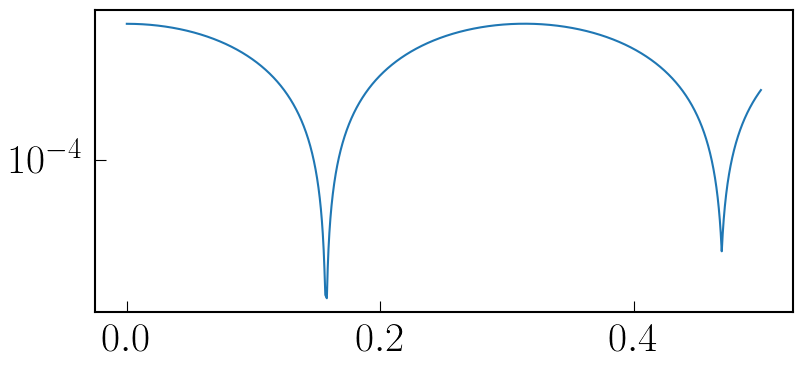

In [18]:
pl.semilogy(time_array, n_data-1)

In [19]:
af.min(f_n)

1.9989660817971786e-31

In [20]:
af.min(f_n_plus_half)

1.998966102347531e-31

In [21]:
af.min(f_n_init)

1.9989497747718904e-31

In [22]:
af.min(f_n_plus_half_init)

1.9989497747718904e-31

Text(0, 0.5, '$\\overline{|f_1-f_2|}$')

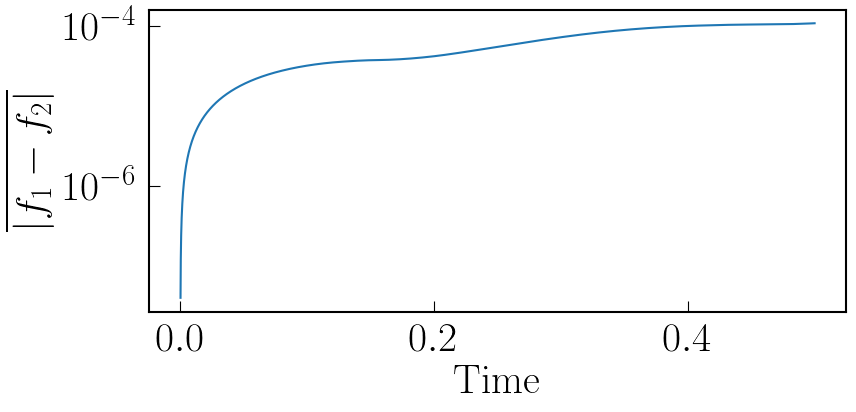

In [26]:
pl.semilogy(time_array, err_data)
pl.xlabel('Time')
pl.ylabel(r'$\overline{|f_1-f_2|}$')